In [83]:
import numpy as np
from matplotlib import pyplot as plt
import os

In [84]:
# low depth variance image same plane
#           x   y      x'    y'
uvMat = [[1855,1352, 1680, 1305], 
        [2100, 2116, 1914, 2084], 
        [2482, 1994, 2310, 1984], 
        [3070, 1336, 2959, 1337], 
        [3450, 1911, 3369, 1966], 
        [1356, 1885, 1173, 1809],
        [3415,2125, 3320, 2190], 
        [3848, 1308, 3846, 1342]]

# low depth variance different plane
uvMat1 = [[1855,1352, 1680, 1305], 
         [1251,2640, 960, 2518], 
         [525, 2436, 323, 2273], 
         [745, 1840, 611,1734], 
         [1578, 2890, 1174, 2783], 
         [1356, 1885, 1173, 1809],
         [3415,2125, 3320, 2190], 
         [3848, 1308, 3846, 1342]]

# high depth variance image same plane
uvMat2 = [[580, 2362, 492, 1803], 
          [2050, 2097, 1381, 1956], 
          [2558, 2174, 1544, 2115], 
          [1395, 1970, 1166, 1752], 
          [2490, 3003, 466, 2440], 
          [3368, 1622, 3320, 2011],
          [2183, 1500, 2471,1621], 
          [1972,1775, 1674, 1736]]

# high depth variance image different plane
uvMat3 = [[580, 2362, 492, 1803],
          [3316,1276, 3242, 1565], 
          [1007,788, 1606,885] , 
          [1900, 1144, 2330, 1250], 
          [984, 1369, 1574, 1335], 
          [3368, 1622, 3320, 2011],
          [2192, 1288, 2469, 1420], 
          [2050, 2097, 1381, 1956]]

In [85]:
def load_imgs():
    close1  = plt.imread("res/same1.jpg")
    close2 = plt.imread('res/same2.jpg')
    far1  = plt.imread("res/extreme1.jpg")
    far2 = plt.imread('res/extreme2.jpg')
    return close1, close2, far1, far2

In [86]:
from functools import reduce
def normalize(points):
    # T1 acts on x,y to give x_hat
    # T2 acts on x'y' to give x'_hat 
    n = len(points)
    img1_pts, img2_pts = [], []
    for a,b,c,d in points:
        img2_pts.append([a,b])
        img1_pts.append([c,d])
    
    sum1 = reduce(lambda x, y:  (x[0]+y[0], x[1]+y[1]), img1_pts)
    sum2 = reduce(lambda x, y:  (x[0]+y[0], x[1]+y[1]), img2_pts)
    # x평균, y평균
    mean1 = [val/n for val in sum1]
    mean2 = [val/n for val in sum2]

    s1 = (2*n)**0.5/(sum([((x-mean1[0])**2 + (y-mean1[1])**2)**0.5 for x,y in img1_pts]))
    s2 = (2*n)**0.5/(sum([((x-mean2[0])**2 + (y-mean2[1])**2)**0.5 for x,y in img2_pts]))

    T1 = np.array([[s1, 0, -mean1[0]*s1], [0, s1, -mean1[1]*s1], [0, 0, 1]])
    T2 = np.array([[s2, 0, -mean2[0]*s2], [0, s2, -mean2[1]*s2], [0, 0, 1]])

    points = [[T1 @ [c, d, 1], T2 @ [a,b,1]] for a,b,c,d in points]
    points = [[r[0], r[1], l[0], l[1]] for l,r in points]
    return points, T1, T2

In [87]:
def calc_F(uvMat):
    A = np.zeros((len(uvMat),9))
    # img1 x' y' x y im2
    for i in range(len(uvMat)):
        A[i][0] = uvMat[i][0]*uvMat[i][2]
        A[i][1] = uvMat[i][1]*uvMat[i][2]
        A[i][2] = uvMat[i][2]
        A[i][3] = uvMat[i][0]*uvMat[i][3]
        A[i][4] = uvMat[i][1]*uvMat[i][3]
        A[i][5] = uvMat[i][3] 
        A[i][6] = uvMat[i][0]
        A[i][7] = uvMat[i][1]
        A[i][8] = 1.0  
    
    _,_,v = np.linalg.svd(A)
    # print("v", v)
    f_vec = v.transpose()[:,8]
    # print("f_vec = ", f_vec)
    f_hat = np.reshape(f_vec, (3,3))
    # print("Fmat = ", f_hat)

    # Enforce rank(F) = 2 
    s,v,d = np.linalg.svd(f_hat)
    f_hat = s @ np.diag([*v[:2], 0]) @ d

    return f_hat

In [88]:
# Restore to the original coordinates
def restore(f_hat, T1, T2):
    f_mat = T2.transpose() @ f_hat @ T1     #  외적, # normalized fundametal을 원래대로 되돌림 
    return f_mat 

In [89]:
cmap = plt.get_cmap("jet_r")
# plot on img1
def plot1(img, f_mat, points):
    w = img.shape[1]
    num = 1
    for x, y, *pt in points:
        color = cmap(num/len(points))
        a,b,c = np.array([*pt, 1]).transpose() @ f_mat      # epipolar line l = Fx : a*ur + b*vr + c = 0
        p1 = (0,-c/b)
        p2 = (w, -(a*w + c)/b)
        plt.plot(*zip(p1,p2), color=color)
        plt.plot(x, y, "x",color=color)
        plt.text(x,y,f"{num}")
        num+=1
    plt.imshow(img)

# plot on img 2 
# epipolar lines based on  x'y' and points x,y
def plot2(img, f_mat, points):
    w = img.shape[1]
    num = 1
    for *pt, x,y in points:
        color = cmap(num/len(points))
        a,b,c = f_mat @ [*pt, 1]                           # epipolar line l = Fx : a*ur + b*vr + c = 0
        p1 = (0,-c/b)
        p2 = (w, -(a*w + c)/b)
        plt.plot(*zip(p1,p2), color=color)
        plt.plot(x,y, "x", color=color)
        plt.text(x,y,f"{num}")
        num+=1
    plt.imshow(img)

## 시작

In [90]:
def main(img1,img2,uvMat):
    norm_points, T1, T2 = normalize(uvMat)      # normalize 이상해서 뺌
    
    f_hat = calc_F(uvMat)

    f_mat = restore(f_hat, T1, T2)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(1,2,1)
    plot1(img1, f_hat, uvMat) 
    ax2 = fig.add_subplot(1,2,2)
    plot2(img2, f_hat, uvMat)

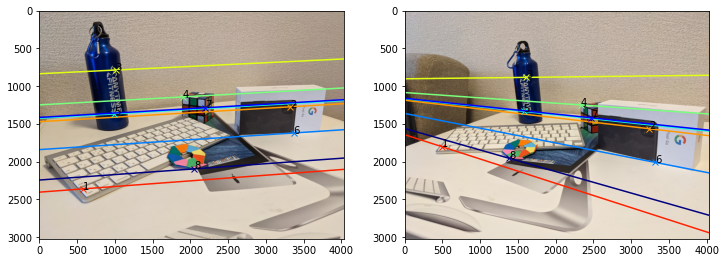

In [91]:
close1, close2, far1, far2 = load_imgs()
main(far1,far2,uvMat3)

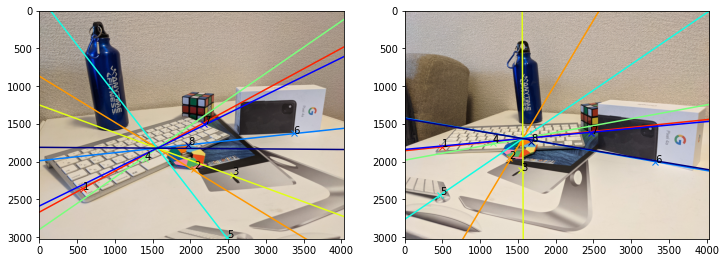

In [92]:
close1, close2, far1, far2 = load_imgs()
main(far1,far2,uvMat2)

In [93]:
# 좌표값 normalize해서 fundametal 구하고 restore로 다시 원래 크기로 돌려서 보면 이상함 
def main(img1,img2,uvMat):
    norm_points, T1, T2 = normalize(uvMat)      # normalize 이상해서 뺌
    
    f_hat = calc_F(norm_points)

    f_mat = restore(f_hat, T1, T2)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(1,2,1)
    plot1(img1, f_mat, uvMat) 
    ax2 = fig.add_subplot(1,2,2)
    plot2(img2, f_mat, uvMat)

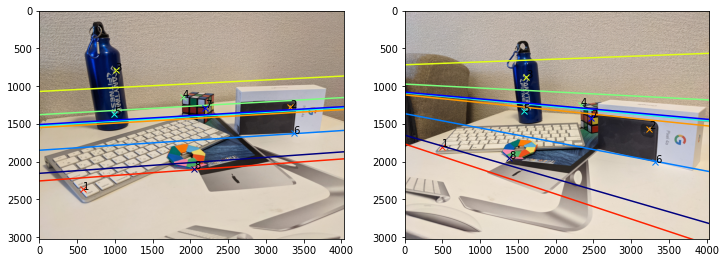

In [94]:
main(far1,far2,uvMat3)  # 이상함 해결필요